In [1]:
import pandas as pd
url = 'Data/City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month - City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
df = pd.read_csv(url)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

In [3]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [7]:
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22462,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,NaN,NaN,...,198490.0,198467.0,196420.0,192002.0,191634.0,189383.0,191134.0,191343.0,192384.0,192110.0
22463,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,NaN,NaN,...,229251.0,232984.0,238245.0,240154.0,242470.0,243119.0,249098.0,255572.0,261910.0,264685.0
22464,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,53380.0,53662.0,...,132490.0,134951.0,137470.0,137430.0,137413.0,137615.0,138908.0,140096.0,141573.0,142438.0
22465,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,258191.0,261607.0,264571.0,266255.0


In [8]:
id_vars = df.columns[:8]
id_vars

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'],
      dtype='object')

In [9]:
largest_cities = pd.melt(df[df['SizeRank'].isin([0,1,2,3])],
             id_vars=id_vars, var_name='Date', value_name='Value')
largest_cities

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Date,Value
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...,...,...,...,...
1087,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [10]:
largest_cities['Date'] = pd.to_datetime(largest_cities['Date'])
largest_cities = largest_cities.set_index('Date')
largest_cities

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Value
Date,,,,,,,,,
2000-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-02-29,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0
...,...,...,...,...,...,...,...,...,...
2022-08-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,315587.0
2022-09-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,781622.0
2022-09-30,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,966595.0


In [11]:
NewYork = largest_cities[largest_cities['RegionName']=='New York']
NewYork

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Value
Date,,,,,,,,,
2000-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-02-29,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0
2000-03-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,257207.0
2000-04-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,260310.0
2000-05-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,263204.0
...,...,...,...,...,...,...,...,...,...
2022-05-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,768797.0
2022-06-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,773944.0
2022-07-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,777692.0


In [12]:
NewYork.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
State         0
Metro         0
CountyName    0
Value         1
dtype: int64

In [13]:
NewYork = NewYork.drop(columns=['RegionID','SizeRank', 'RegionType','StateName','State','Metro','CountyName',])

In [14]:
NewYork_monthly = NewYork.groupby('RegionName').resample('MS').sum()

C:\Users\User\AppData\Local\Temp\ipykernel_14088\1008750841.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  NewYork_monthly = NewYork.groupby('RegionName').resample('MS').sum()


In [15]:
NewYork_monthly

Value
RegionName Date                
New York   2000-01-01  253690.0
           2000-02-01  255517.0
           2000-03-01  257207.0
           2000-04-01  260310.0
           2000-05-01  263204.0
...                         ...
           2022-05-01  768797.0
           2022-06-01  773944.0
           2022-07-01  777692.0
           2022-08-01  779960.0
           2022-09-01  781622.0

[273 rows x 1 columns]

In [16]:
unst = NewYork_monthly.unstack(level=0)
unst

,Value
RegionName,New York
Date,
2000-01-01,253690.0
2000-02-01,255517.0
2000-03-01,257207.0
2000-04-01,260310.0
2000-05-01,263204.0
...,...
2022-05-01,768797.0
2022-06-01,773944.0


Filtering Data

In [17]:
unstDateRange = unst.loc['2018':]
unstDateRange

,Value
RegionName,New York
Date,
2018-01-01,656700.0
2018-02-01,661012.0
2018-03-01,665672.0
2018-04-01,669989.0
2018-05-01,673514.0
2018-06-01,676434.0
2018-07-01,678984.0
2018-08-01,681140.0


In [18]:
NewYork = unstDateRange['Value']
NewYork = NewYork['New York']
NewYork

Date
2018-01-01    656700.0
2018-02-01    661012.0
2018-03-01    665672.0
2018-04-01    669989.0
2018-05-01    673514.0
2018-06-01    676434.0
2018-07-01    678984.0
2018-08-01    681140.0
2018-09-01    683546.0
2018-10-01    685588.0
2018-11-01    688553.0
2018-12-01    691226.0
2019-01-01    693208.0
2019-02-01    694425.0
2019-03-01    695720.0
2019-04-01    695824.0
2019-05-01    696173.0
2019-06-01    695186.0
2019-07-01    695010.0
2019-08-01    692926.0
2019-09-01    690189.0
2019-10-01    687693.0
2019-11-01    686304.0
2019-12-01    686650.0
2020-01-01    688073.0
2020-02-01    689697.0
2020-03-01    690055.0
2020-04-01    690520.0
2020-05-01    689921.0
2020-06-01    690785.0
2020-07-01    691384.0
2020-08-01    693097.0
2020-09-01    694261.0
2020-10-01    696260.0
2020-11-01    698929.0
2020-12-01    701899.0
2021-01-01    703956.0
2021-02-01    705003.0
2021-03-01    706066.0
2021-04-01    707633.0
2021-05-01    710706.0
2021-06-01    714507.0
2021-07-01    719155.0
2021-0

Check for null values. No nulls

In [19]:
NewYork.isna().sum()

0

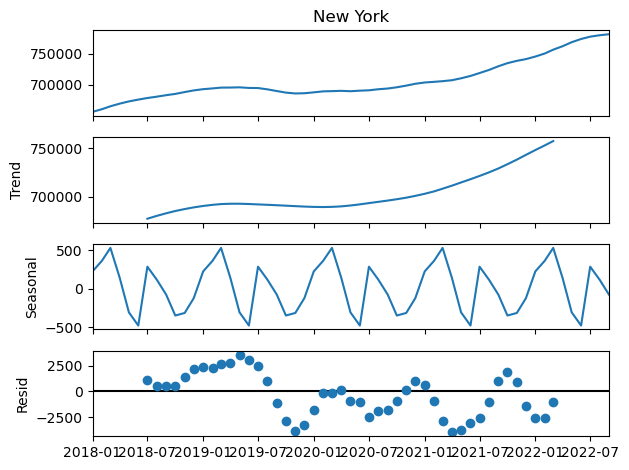

In [20]:
decomp = tsa.seasonal_decompose(NewYork)
decomp.plot();

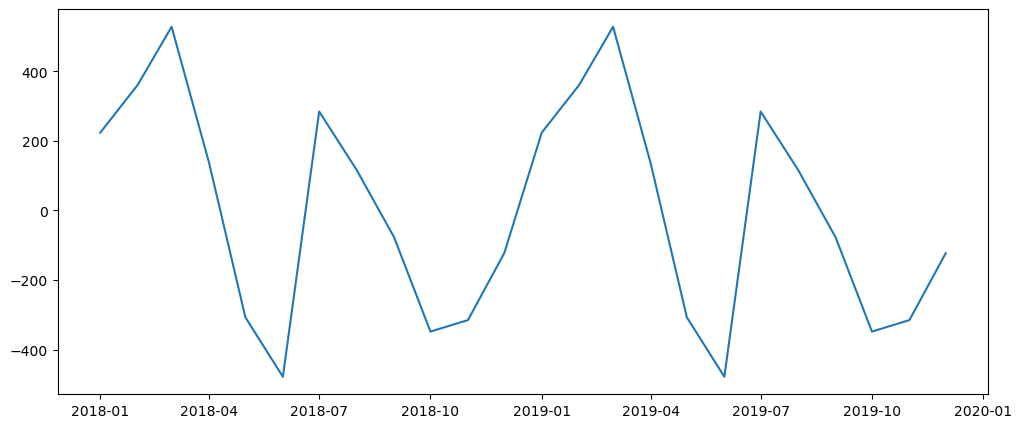

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(decomp.seasonal.loc['2018':'2019']);


Values don't seem to change that much in any given period. I would say nonseasonal. This plot shows only about an 1000 dollar difference between highest and lowest value, which isn't much relative to what houses cost. 

In [25]:
# Testing the function
adfuller_results = get_adfuller_results(NewYork)
adfuller_results



,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.407572,4,52,0.981776,0.05,False


In [24]:
d = ndiffs(NewYork)
D = nsdiffs(NewYork, m=12)
d, D

(2, 0)

In [27]:
NewYork_diff_diff = NewYork.diff().diff().dropna()

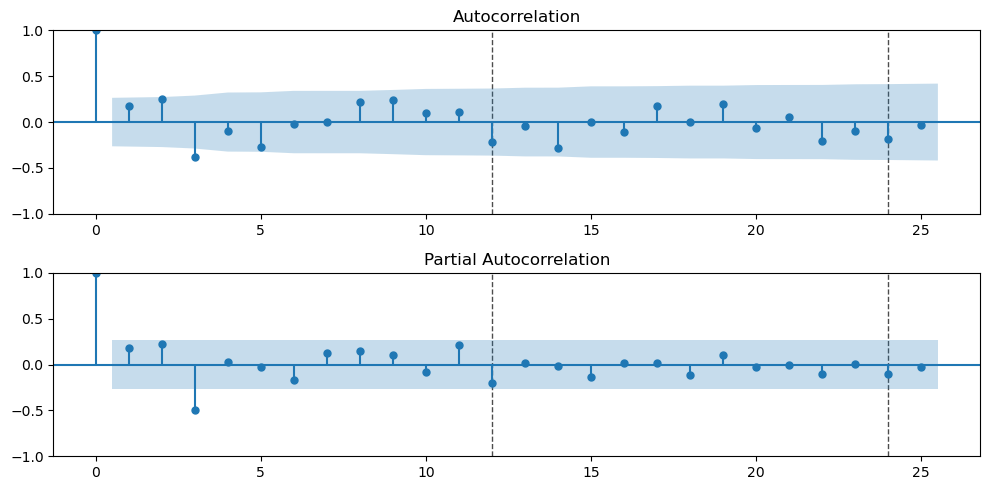

In [32]:
plot_acf_pacf(NewYork_diff_diff, m=12, pacf_kws={'method':'ywm'}, annotate_seas=True, nlags=25);

In [34]:
# Order I determined
p = 1
d = 2
q = 0



In [33]:
train, test = train_test_split(NewYork, test_size=6)

In [35]:
arima = tsa.ARIMA(train, order=(p,d,q)).fit()

In [36]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               New York   No. Observations:                   51
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -402.198
Date:                Thu, 07 Dec 2023   AIC                            808.395
Time:                        13:56:46   BIC                            812.179
Sample:                    01-01-2018   HQIC                           809.831
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0014      0.097     -0.014      0.988      -0.191       0.188
sigma2      7.852e+05    2.2e+05      3.564      0.000    3.53e+05    1.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.25   Prob(JB):                         0.39
Heteroskedasticity (H):               2.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
arima_forecast = arima.get_forecast(steps=len(test)).summary_frame()

In [39]:
arima_forecast['mean']

2022-04-01    762888.233152
2022-05-01    769042.468774
2022-06-01    775196.704392
2022-07-01    781350.940011
2022-08-01    787505.175629
2022-09-01    793659.411247
Freq: MS, Name: mean, dtype: float64

## ARIMA Forecast

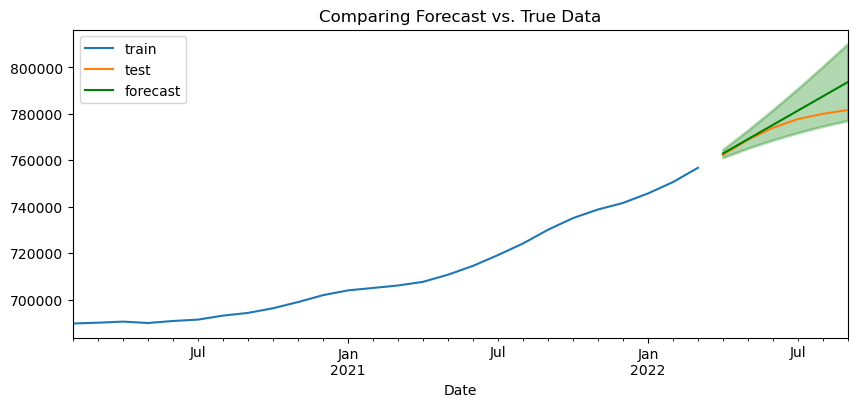

In [40]:
plot_forecast(train,test, arima_forecast, n_train_lags=26);

In [41]:
regression_metrics_ts(test, arima_forecast['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4,217.822
- MSE = 36,194,677.245
- RMSE = 6,016.201
- R^2 = 0.198
- MAPE = 0.54%


In [45]:
auto_model = pm.auto_arima(train, seasonal=False)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -449.603
Date:                Thu, 07 Dec 2023   AIC                            907.207
Time:                        14:08:18   BIC                            914.855
Sample:                    01-01-2018   HQIC                           910.119
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    593.8235   1281.381      0.463      0.643   -1917.637    3105.283
ar.L1          0.6749      0.693      0.974      0.330      -0.683       2.032
ma.L1         -0.6674      0.694     -0.962      0.336      -2.028       0.693
sigma2      3.622e+06      0.252   1.44e+07      0.000    3.62e+06    3.62e+06
===================================================================================
Ljung-Box (L1) (Q):                  37.34   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.00   Prob(JB):                         0.99
Heteroskedasticity (H):               4.84   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.08e+24. Standard errors may be unstable.
"""

In [46]:
auto_model.order

(1, 1, 1)

In [47]:
auto_model_fit = tsa.ARIMA(train, order = auto_model.order).fit()

In [48]:
auto_model_forecast = auto_model_fit.get_forecast(steps=len(test)).summary_frame()

## Auto Model Forecast

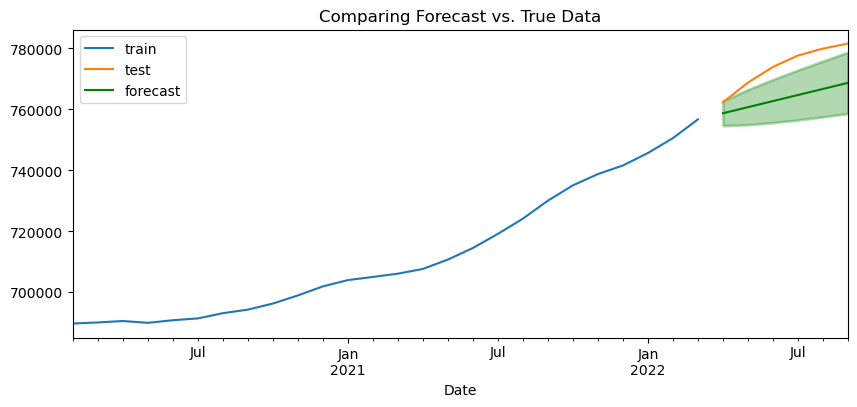

In [49]:
plot_forecast(train, test, auto_model_forecast, n_train_lags=26);

In [50]:
regression_metrics_ts(test, auto_model_forecast['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 10,336.391
- MSE = 119,088,166.132
- RMSE = 10,912.752
- R^2 = -1.640
- MAPE = 1.33%


## Future Forecast

In [53]:
future = tsa.ARIMA(NewYork, order =(p,d,q)).fit()
future_forecast = future.get_forecast(steps=6).summary_frame()

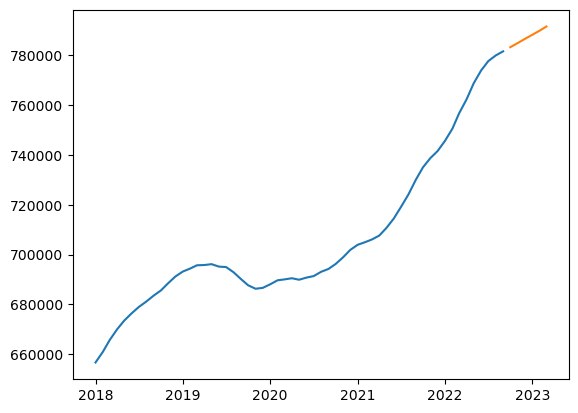

In [54]:
plt.plot(NewYork)
plt.plot(future_forecast['mean'])

What is the predicted home value in New York City 6 months into the future?

In [57]:
future_price = future_forecast['mean'].iloc[-1]
price = "${:.2f}".format(future_price)
print(price)

$791598.80


What is the percent change in home values in New York City by the end of the 6-month forecast?

In [59]:
NewYork_maxPrice = NewYork.iloc[-1]
price_diff_future = future_price - NewYork_maxPrice
price_diff_future

9976.798264590208

In [62]:
percent_difference = (price_diff_future/NewYork_maxPrice) * 100
percent_difference
percent = "{:.2f}%".format(percent_difference)
print(percent)

1.28%
